In [1]:
import os
import gc
import ot
import pickle
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import commot as ct

In [2]:
spdatapath='./inputQuery/'
ad_spatial_ori=sc.read_h5ad(spdatapath+'common_counts_sp.h5ad')
coordinate = pd.read_csv(spdatapath+'tissue_positions_list.csv')
coordinate=coordinate.to_numpy()

print(coordinate.shape,ad_spatial_ori)

df=pd.read_csv(spdatapath+'MNN_based_annotations/3_nico_annotation_ct_name.csv')
sc_ctype_name=df.to_numpy()

df=pd.read_csv(spdatapath+'MNN_based_annotations/3_nico_annotation_cluster.csv')
nico_cluster=df.to_numpy()
cellname=nico_cluster[:,0]

print("equal",np.array_equal(cellname,ad_spatial_ori.obs_names))


d={}
for i in range(len(sc_ctype_name)):
    d[i]=sc_ctype_name[i][1]

ctname=[]
for i in range(len(cellname)):
        ctname.append( d[ nico_cluster[i,1]])

ad_spatial_ori.obs['nico_ct']=ctname

sc_ctype_name=coordinate[:,0]
d={}
for i in range(len(sc_ctype_name)):
    d[sc_ctype_name[i]]=i

index=[]
for i in range(len(cellname)):
    index.append( d[ cellname[i]])

coordinate1=coordinate[index]
print("equal",np.array_equal(cellname,coordinate1[:,0]),coordinate1.shape)

#because it is 2d tissue slide so only upload the X and Y coordiante
ad_spatial_ori.obsm['spatial']=coordinate1[:,[1,2]].astype(float)
adata=ad_spatial_ori
sample=[]
for i in range(len(ad_spatial_ori.obs_names)):
    sample.append('batch0')


adata.obs['sample']=np.array(sample)
adata.obs['sample']=pd.Categorical(adata.obs['sample'])

print('1',adata)

index=[]
for i in range(len(ctname)):
    flag=1
    if adata.obs['nico_ct'][i]=='NM':
        flag=0
    if adata.obs['nico_ct'][i]=='HsPCs':
        flag=0
    if adata.obs['nico_ct'][i]=='Basophils':
        flag=0
    if adata.obs['nico_ct'][i]=='NK cells':
        flag=0
    if flag==1:
        index.append(i)


adata=adata[index]
print('2',adata)

(395215, 3) AnnData object with n_obs × n_vars = 391678 × 342
    obs: 'n_counts'
equal True
equal True (391678, 3)
1 AnnData object with n_obs × n_vars = 391678 × 342
    obs: 'n_counts', 'nico_ct', 'sample'
    obsm: 'spatial'
2 View of AnnData object with n_obs × n_vars = 374905 × 342
    obs: 'n_counts', 'nico_ct', 'sample'
    obsm: 'spatial'


In [3]:
#adata.var_names_make_unique()
adata.raw = adata
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [4]:
adata_dis500 = adata.copy()

In [5]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
#sc.tl.leiden(adata, resolution=0.4)


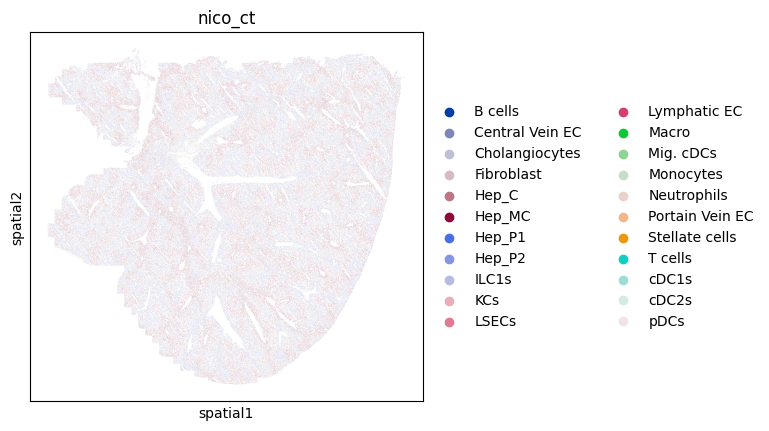

In [6]:
sc.pl.spatial(adata, color='nico_ct',spot_size=5)

In [7]:
df_cellchat = ct.pp.ligand_receptor_database(species='mouse',  database='CellChat') #signaling_type='Secreted Signaling',
print(df_cellchat.shape)
# We then filter the LR pairs to keep only the pairs with both ligand and receptor expressed in at least 5% of the spots.
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata_dis500, min_cell_pct=0)
print(df_cellchat_filtered.shape)

(1209, 4)
(3, 4)


In [8]:
df_cellchat_filtered

,0,1,2,3
0,Angpt1,Tek,ANGPT,Secreted Signaling
1,Angpt2,Tek,ANGPT,Secreted Signaling
2,Kitl,Kit,KIT,Secreted Signaling


In [9]:
df1=pd.read_csv('./../NiCoLRdb.txt',header=None,sep='\t')
df2=df1.to_numpy().astype(str)
df=np.char.capitalize(df2)
print(df)

[['A2m' 'Lrp1' '# natmi_primary# natmi_additional']
 ['Aanat' 'Mtnr1a' '# natmi_primary# natmi_additional']
 ['Aanat' 'Mtnr1b' '# natmi_primary# natmi_additional']
 ...
 ['Zp3' 'Egfr' '# natmi_primary# natmi_additional# omnipath']
 ['Zp3' 'Mertk' '# natmi_additional# omnipath']
 ['Zp3' 'Mert' '# natmi_primary']]


In [10]:
df_cellchat = pd.DataFrame(data=df)
df_cellchat.shape

(4372, 3)

In [11]:
#ct.pp.ligand_receptor_database()

In [12]:
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata_dis500, min_cell_pct=0.05)
print(df_cellchat_filtered.shape)

(79, 3)


In [13]:
df_cellchat_filtered

,0,1,2
0,Alcam,Nrp1,# natmi_primary# natmi_additional
1,Angpt1,Tek,# cellphonedb# natmi_primary# natmi_additional...
2,Angpt2,Tek,# cellphonedb# natmi_primary# natmi_additional...
3,Bmp2,Eng,# natmi_primary# natmi_additional
4,Bmp7,Eng,# natmi_primary# natmi_additional
...,...,...,...
74,Wnt4,Fzd3,# natmi_additional# omnipath
75,Wnt4,Fzd4,# natmi_additional
76,Wnt4,Fzd5,# natmi_additional
77,Wnt4,Fzd7,# natmi_additional


In [14]:
ct.tl.spatial_communication(adata_dis500,
    database_name='nico_db', df_ligrec=df_cellchat_filtered, dis_thr=5, heteromeric=True, pathway_sum=True)

MemoryError: Unable to allocate 1.02 TiB for an array with shape (374905, 374905) and data type float64

In [ ]:
adata_dis500.write("output_commot_liver.h5ad")